In [ ]:
# this is largely based on the tutorials at: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import datetime
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler


In [2]:
# settings
model_settings = {'epochs': 100, 'batch_size': 4, 'train_test_ratio': 0.7, 'hidden_layers': 3, 'units': 100, 'start_date': '2020-01-01', 'n_steps_in': 3, 'n_steps_out': 2, 'symbol': 'CTXR'}
current_date = datetime.datetime.now().strftime("%Y-%m-%d")


In [3]:
# load and shape data
conn = sqlite3.connect('stockPrediction_06072021.db')

symbol_info = conn.execute(f"SELECT sector_id, industry_id FROM stock WHERE stock_symbol = \"{model_settings['symbol']}\";")
symbol_info = symbol_info.fetchall()
sector_id = symbol_info[0][0]
industry_id = symbol_info[0][1]

query = f"SELECT r.stock_symbol, l.price_datetime, l.open_price, l.high_price, l.low_price, l.close_price, l.volume, l.dividends, l.stock_splits FROM eod_price_history l INNER JOIN stock r ON r.stock_id = l.stock_id WHERE r.sector_id = {sector_id} OR r.industry_id = {industry_id};"

symbols = conn.execute('SELECT stock_symbol FROM stock')
symbols = symbols.fetchall()
symbols = [i[0] for i in symbols]
symbols = [i for i in symbols if i not in symbols]

df = pd.read_sql(query, conn, index_col=['stock_symbol', 'price_datetime'])
df = df.reset_index()

df['price_datetime'] = pd.to_datetime(df['price_datetime'], format='%Y-%m-%d')

df = df.set_index(['price_datetime', 'stock_symbol']).unstack(['stock_symbol'])

df = df.loc[model_settings['start_date']:current_date]  # date range from 2019-01-01 to 2021-05-31

close_df = df['close_price'].dropna(thresh=(len(df['close_price'] / 0.2)), axis=1)

close_df = close_df.fillna(method='ffill', axis=1)

# remove outliers
low_outlier = close_df.quantile(.1, axis=1).quantile(.1)
high_outlier = close_df.quantile(.9, axis=1).quantile(.9)
for column in close_df.columns:
    if (close_df[column].median() < low_outlier) or (close_df[column].median() > high_outlier):
        close_df = close_df.drop([column], axis=1)
columns = [i for i in close_df.columns]
close_df

stock_symbol,ABEO,ABIO,ABMC,ABMT,ABUS,ACER,ACHFF,ACRX,ACST,ACUR,...,XPHYF,XTLB,XTNT,XXII,YCBD,ZIOP,ZIVO,ZOM,ZSAN,ZYNE
price_datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-02,3.210,5.6800,0.0700,0.10000,2.94,3.790,0.7410,2.070,2.3800,0.280,...,0.75,1.3000,1.580,1.140,2.3400,4.6200,0.160,0.3310,1.5200,5.8800
2020-01-03,2.900,5.5600,0.0700,0.10000,3.08,3.580,0.7410,2.040,2.3300,0.280,...,0.75,1.4100,1.530,1.090,2.2700,4.5000,0.160,0.3320,1.5500,5.8100
2020-01-06,2.770,5.6300,0.0700,0.10000,3.18,3.690,0.7410,2.010,2.2100,0.280,...,0.75,1.4200,1.550,1.100,2.2200,4.4900,0.160,0.3130,1.6400,5.7000
2020-01-07,2.570,5.6700,0.0800,0.10000,3.04,3.710,0.7250,2.070,2.3300,0.240,...,0.75,1.4100,1.590,1.090,1.8400,4.5300,0.160,0.3130,1.7100,5.5600
2020-01-08,2.620,6.0700,0.0800,0.10000,3.07,3.690,0.7330,2.030,2.1900,0.240,...,0.75,1.2600,1.580,1.070,1.5900,4.5900,0.160,0.3200,1.6200,5.3100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-01,1.710,3.4900,0.0636,0.07920,2.86,2.960,1.1180,1.430,0.5071,0.365,...,1.80,3.5400,1.450,4.600,2.9300,3.0700,4.255,0.8239,0.8025,5.0700
2021-06-02,1.745,3.5690,0.0645,0.11490,3.02,2.910,1.1400,1.440,0.5290,0.365,...,1.82,3.5500,1.488,4.650,3.1550,3.0400,4.145,0.8379,0.8006,5.2800
2021-06-03,1.825,3.7000,0.0631,0.07609,2.90,2.881,1.1400,1.445,0.5373,0.365,...,1.74,3.5242,1.660,4.645,3.1500,3.1400,4.290,1.0050,0.8069,5.1819


In [4]:
# split sequences function, splits multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find end of patterns
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check to see if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input, output parts of the pattern
        # slightly guessing here on how to combine these two examples
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [5]:
# minmax all data
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(close_df.values)

In [6]:
# split into test/train data sets

# splitting test/training data
data_size = len(scaled)

# using a 90/10 train/test split
training_data = scaled[:(int(data_size * model_settings['train_test_ratio']))]
test_data = scaled[(int(data_size * model_settings['train_test_ratio'])):]

In [7]:
# may just be able to jump right into using the split_sequence func?
X, y = split_sequences(training_data, model_settings['n_steps_in'], model_settings['n_steps_out'])

In [8]:
n_features = X.shape[2]

In [9]:
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [10]:
# define model
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(model_settings['n_steps_in'], n_features)))
model.add(RepeatVector(model_settings['n_steps_out']))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
# model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')

In [11]:
# fit model
model.fit(X, y, epochs=10, verbose=1)

Epoch 1/10
8/8 [==============================] - 2s 20ms/step - loss: 0.1167
Epoch 2/10
8/8 [==============================] - 0s 19ms/step - loss: 0.0540
Epoch 3/10
8/8 [==============================] - 0s 20ms/step - loss: 0.0300
Epoch 4/10
8/8 [==============================] - 0s 20ms/step - loss: 0.0216
Epoch 5/10
8/8 [==============================] - 0s 20ms/step - loss: 0.0167
Epoch 6/10
8/8 [==============================] - 0s 20ms/step - loss: 0.0136
Epoch 7/10
8/8 [==============================] - 0s 20ms/step - loss: 0.0116
Epoch 8/10
8/8 [==============================] - 0s 20ms/step - loss: 0.0102
Epoch 9/10
8/8 [==============================] - 0s 20ms/step - loss: 0.0089
Epoch 10/10
8/8 [==============================] - 0s 19ms/step - loss: 0.0082


In [12]:
# feed the model we used to train it to make some predictions
test_X, test_y = split_sequences(test_data, model_settings['n_steps_in'], model_settings['n_steps_out'])
#test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
yhat = model.predict(test_X, verbose=1)
# print(yhat)

4/4 [==============================] - 0s 4ms/step


In [13]:
yhat = yhat.reshape((-1, X.shape[2]))

In [14]:
yhat = scaler.inverse_transform(yhat)

In [15]:
predicted_data = pd.DataFrame(yhat, columns=columns)

In [16]:
predicted_data

,ABEO,ABIO,ABMC,ABMT,ABUS,ACER,ACHFF,ACRX,ACST,ACUR,...,XPHYF,XTLB,XTNT,XXII,YCBD,ZIOP,ZIVO,ZOM,ZSAN,ZYNE
0,1.299060,4.148043,0.077484,0.198339,3.761986,2.745396,1.137794,1.535018,0.186230,0.245516,...,1.535591,2.593544,1.252984,1.890013,2.789139,2.847952,-0.044570,0.129362,0.584794,3.988541
1,1.406993,4.650007,0.048694,0.209065,3.810174,2.708019,1.122648,1.460900,0.258404,0.247422,...,1.515762,2.653066,1.331577,2.077801,2.796246,2.904796,-0.090219,0.164344,0.539028,4.067696
2,1.311132,4.257446,0.084356,0.207941,3.879975,2.843032,1.162652,1.559045,0.187256,0.249338,...,1.574757,2.657760,1.285341,1.924328,2.916975,2.902673,-0.065393,0.123487,0.610291,4.035874
3,1.407777,4.778500,0.055859,0.215600,3.868123,2.786126,1.133687,1.464519,0.267077,0.248537,...,1.538000,2.689967,1.363872,2.097753,2.876831,2.948940,-0.109917,0.161361,0.560484,4.092749
4,1.306924,4.338068,0.082054,0.214737,3.991501,2.893044,1.184788,1.592656,0.187502,0.252860,...,1.596949,2.714406,1.309450,1.973848,3.022932,2.943790,-0.093248,0.115069,0.617057,4.112698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,1.647911,5.769748,0.088542,0.242946,4.237947,3.375173,1.165062,1.539235,0.344922,0.245464,...,1.626686,2.885695,1.471367,2.202529,3.158655,3.342597,-0.307245,0.085114,0.641764,4.708704
206,1.486508,4.905146,0.093445,0.241549,4.480429,3.481920,1.253700,1.708982,0.216281,0.260524,...,1.724791,2.953887,1.329641,2.143805,3.461607,3.315313,-0.313084,0.058825,0.698198,4.627441
207,1.636284,5.767006,0.083127,0.244683,4.268459,3.376859,1.170571,1.546157,0.339521,0.245290,...,1.643592,2.911363,1.457669,2.231290,3.195883,3.341183,-0.330277,0.073608,0.637730,4.707705
208,1.472203,4.866341,0.088958,0.242557,4.514205,3.478539,1.262537,1.724589,0.201291,0.260657,...,1.734165,2.977841,1.331646,2.164444,3.505257,3.308782,-0.332774,0.044495,0.699494,4.637960


In [39]:
# convert training/test data back into dataframes for ease of plotting...
training_data = pd.DataFrame(training_data, columns=columns)
training_data['price_datetime'] = close_df.index[:len(training_data)]
training_data = training_data.set_index('price_datetime')
test_data = pd.DataFrame(test_data, columns=columns)
test_data['price_datetime'] = close_df.index[len(training_data):]

ValueError: Length of values (109) does not match length of index (210)

In [33]:
len(predicted_data), len(test_data)

(210, 210)

In [25]:
test_data

,ABEO,ABIO,ABMC,ABMT,ABUS,ACER,ACHFF,ACRX,ACST,ACUR,...,XTLB,XTNT,XXII,YCBD,ZIOP,ZIVO,ZOM,ZSAN,ZYNE,price_datetime
0,0.192810,0.104204,0.061947,0.187500,0.531191,0.318376,0.786667,0.243781,0.081818,0.137931,...,0.698462,0.167116,0.355731,0.413207,0.202703,0.016393,0.061907,0.137848,0.071672,2020-12-30
1,0.179739,0.100059,0.061947,0.187500,0.499055,0.307692,0.786667,0.238806,0.068182,0.241379,...,0.655385,0.156334,0.324111,0.414959,0.167568,0.016393,0.062286,0.115478,0.068259,2020-12-31
2,0.218954,0.108940,0.061947,0.187500,0.516068,0.290598,0.813333,0.243781,0.100000,0.241379,...,0.800000,0.164420,0.316206,0.369417,0.248649,0.016393,0.107482,0.148730,0.072526,2021-01-04
3,0.235294,0.114861,0.061947,0.187500,0.499055,0.294872,0.785333,0.303483,0.154545,0.241379,...,0.769231,0.191375,0.318182,0.367665,0.254054,0.016393,0.141284,0.283555,0.083618,2021-01-05
4,0.225490,0.107164,0.070796,0.187500,0.502836,0.277778,0.760000,0.288557,0.113636,0.241379,...,0.720000,0.177898,0.381423,0.383430,0.272973,0.018735,0.130270,0.275091,0.087031,2021-01-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,0.225490,0.069272,0.003186,0.102500,0.368620,0.380342,0.784000,0.333333,0.148682,0.775862,...,0.812308,0.223720,0.798419,0.411456,0.316216,0.977752,0.287467,0.282044,0.370307,2021-06-01
105,0.236928,0.073949,0.003982,0.176875,0.398866,0.369658,0.813333,0.338308,0.158636,0.775862,...,0.815385,0.233962,0.808300,0.450867,0.308108,0.951991,0.292784,0.280895,0.406143,2021-06-02
106,0.263072,0.081705,0.002743,0.096021,0.376182,0.363462,0.813333,0.340796,0.162409,0.775862,...,0.807446,0.280323,0.807312,0.449991,0.335135,0.985948,0.356248,0.284704,0.389403,2021-06-03
107,0.223856,0.078455,0.001770,0.104167,0.396975,0.386752,0.783200,0.363184,0.168318,0.758621,...,0.753846,0.266846,0.817194,0.425434,0.311595,1.000000,0.320547,0.291838,0.389078,2021-06-04


In [32]:
# add datetimes to the predicted data by adding the appropriate amount of dates to the test_df
# calc two weeks from todays date;llllllllll54hg8=[-]
#today = datetime.datetime.now()
#future = datetime.timedelta(days=14)
#two_weeks_from_date = today + future

# test_data = test_data.reset_index()

# future_dates = []

# for now, -2 b/c of my data
'''for date in range (-2, 30):
    future = datetime.timedelta(days=date)
    future = today + future
    if future.weekday() in [5,6]:
        continue
    future = future.strftime('%Y-%m-%d')
    future = pd.to_datetime(future, format='%Y-%m-%d')
    future_dates.append({'price_datetime': future})'''

while len(predicted_data) > len(test_data):
    last_date = test_data['price_datetime'].iloc[-1]
    future_date = last_date + datetime.timedelta(days=1)
    while future_date.weekday() in [5,6]:
        future_date = future_date + datetime.timedelta(days=1)
    future_date = future_date.strftime('%Y-%m-%d')
    future_date = pd.to_datetime(future_date, format='%Y-%m-%d')
    future_dates = {'price_datetime': future_date}
    test_data = test_data.append(future_dates, ignore_index=True)

# test_data = test_data.append(future_dates, ignore_index=True)

test_data = test_data.set_index('price_datetime')
test_data.tail(5)

,ABEO,ABIO,ABMC,ABMT,ABUS,ACER,ACHFF,ACRX,ACST,ACUR,...,XPHYF,XTLB,XTNT,XXII,YCBD,ZIOP,ZIVO,ZOM,ZSAN,ZYNE
price_datetime,,,,,,,,,,,,,,,,,,,,,
2021-10-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
predicted_data['price_datetime'] = test_data.index
predicted_data = predicted_data.set_index('price_datetime')
predicted_data

,ABEO,ABIO,ABMC,ABMT,ABUS,ACER,ACHFF,ACRX,ACST,ACUR,...,XPHYF,XTLB,XTNT,XXII,YCBD,ZIOP,ZIVO,ZOM,ZSAN,ZYNE
price_datetime,,,,,,,,,,,,,,,,,,,,,
2020-12-30,1.299060,4.148043,0.077484,0.198339,3.761986,2.745396,1.137794,1.535018,0.186230,0.245516,...,1.535591,2.593544,1.252984,1.890013,2.789139,2.847952,-0.044570,0.129362,0.584794,3.988541
2020-12-31,1.406993,4.650007,0.048694,0.209065,3.810174,2.708019,1.122648,1.460900,0.258404,0.247422,...,1.515762,2.653066,1.331577,2.077801,2.796246,2.904796,-0.090219,0.164344,0.539028,4.067696
2021-01-04,1.311132,4.257446,0.084356,0.207941,3.879975,2.843032,1.162652,1.559045,0.187256,0.249338,...,1.574757,2.657760,1.285341,1.924328,2.916975,2.902673,-0.065393,0.123487,0.610291,4.035874
2021-01-05,1.407777,4.778500,0.055859,0.215600,3.868123,2.786126,1.133687,1.464519,0.267077,0.248537,...,1.538000,2.689967,1.363872,2.097753,2.876831,2.948940,-0.109917,0.161361,0.560484,4.092749
2021-01-06,1.306924,4.338068,0.082054,0.214737,3.991501,2.893044,1.184788,1.592656,0.187502,0.252860,...,1.596949,2.714406,1.309450,1.973848,3.022932,2.943790,-0.093248,0.115069,0.617057,4.112698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-20,1.647911,5.769748,0.088542,0.242946,4.237947,3.375173,1.165062,1.539235,0.344922,0.245464,...,1.626686,2.885695,1.471367,2.202529,3.158655,3.342597,-0.307245,0.085114,0.641764,4.708704
2021-10-21,1.486508,4.905146,0.093445,0.241549,4.480429,3.481920,1.253700,1.708982,0.216281,0.260524,...,1.724791,2.953887,1.329641,2.143805,3.461607,3.315313,-0.313084,0.058825,0.698198,4.627441
2021-10-22,1.636284,5.767006,0.083127,0.244683,4.268459,3.376859,1.170571,1.546157,0.339521,0.245290,...,1.643592,2.911363,1.457669,2.231290,3.195883,3.341183,-0.330277,0.073608,0.637730,4.707705


Text(0, 0.5, 'Price in USD')

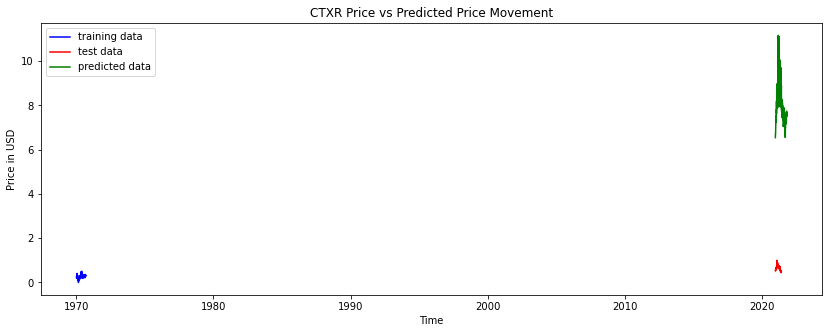

In [36]:
plt.figure(figsize=(14,5))
plt.plot(training_data['CTXR'], color='blue', label='training data')
plt.plot(test_data['IMGN'], color='red', label='test data')
plt.plot(predicted_data['IMGN'], color='green', label='predicted data')
plt.title(f"{model_settings['symbol']} Price vs Predicted Price Movement")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Price in USD")

No handles with labels found to put in legend.


Text(0, 0.5, 'Price in USD')

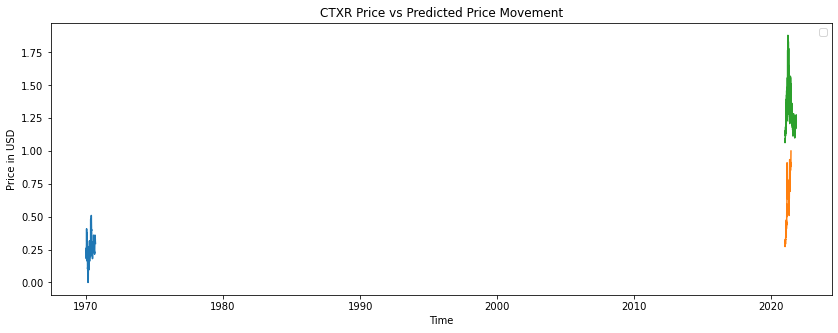

In [37]:
plt.figure(figsize=(14,5))
plt.plot(training_data['CTXR'])
plt.plot(test_data['CTXR'])
plt.plot(predicted_data['CTXR'])
plt.title(f"{model_settings['symbol']} Price vs Predicted Price Movement")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Price in USD")

In [38]:
training_data

,ABEO,ABIO,ABMC,ABMT,ABUS,ACER,ACHFF,ACRX,ACST,ACUR,...,XTLB,XTNT,XXII,YCBD,ZIOP,ZIVO,ZOM,ZSAN,ZYNE,price_datetime
0,0.715686,0.198934,0.008850,0.145833,0.383743,0.557692,0.281333,0.651741,1.000000,0.482759,...,0.123077,0.258760,0.114625,0.308110,0.735135,0.018735,0.100266,0.715840,0.508532,2020-01-02
1,0.614379,0.191829,0.008850,0.145833,0.410208,0.512820,0.281333,0.636816,0.977273,0.482759,...,0.156923,0.245283,0.104743,0.295849,0.702703,0.018735,0.100646,0.733978,0.496587,2020-01-03
2,0.571895,0.195974,0.008850,0.145833,0.429112,0.536325,0.281333,0.621891,0.922727,0.482759,...,0.160000,0.250674,0.106719,0.287091,0.700000,0.018735,0.093430,0.788392,0.477816,2020-01-06
3,0.506536,0.198342,0.017699,0.145833,0.402647,0.540598,0.260000,0.651741,0.977273,0.344828,...,0.156923,0.261456,0.104743,0.220529,0.710811,0.018735,0.093430,0.830713,0.453925,2020-01-07
4,0.522876,0.222025,0.017699,0.145833,0.408318,0.536325,0.270667,0.631841,0.913636,0.344828,...,0.110769,0.258760,0.100791,0.176738,0.727027,0.018735,0.096088,0.776300,0.411263,2020-01-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,0.189543,0.124926,0.044248,0.312500,0.591682,0.299145,0.817333,0.233831,0.031818,0.275862,...,0.541538,0.142857,0.353755,0.402698,0.281081,0.009368,0.047474,0.150544,0.092150,2020-12-22
247,0.254902,0.120782,0.044248,0.354167,0.593573,0.307692,0.834667,0.273632,0.113636,0.275862,...,0.584615,0.148248,0.345850,0.486775,0.270270,0.014052,0.060387,0.170496,0.087031,2020-12-23
248,0.232026,0.114269,0.044248,0.437500,0.559546,0.314103,0.793333,0.253731,0.068182,0.275862,...,0.569231,0.156334,0.341897,0.444736,0.264865,0.016393,0.061527,0.163845,0.088737,2020-12-24
249,0.209150,0.108940,0.070796,0.187500,0.514178,0.294872,0.793333,0.223881,0.059091,0.344828,...,0.627692,0.161725,0.324111,0.425469,0.213514,0.016393,0.069882,0.149335,0.073379,2020-12-28
